# Baseline results: Normalizing Flow with Glow Blocks

As a baseline, we have a NF model without causal understanding. That is, we do not impose a prior distribution that adheres to the causal model implied by the latent causal graph. In addition, we do not maximize the likelihood across the different distributions, but treat the entire dataset as a single distribution

In [2]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.noncausal.flows import (
    CouplingLayer,
    Dequantization,
    GatedConvNet,
    Reshape,
    VariationalDequantization,
    create_channel_mask,
    create_checkerboard_mask,
)
from gendis.noncausal.model import ImageFlow
from gendis.variational.vae import VAE

In [3]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=nrow, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [4]:
seed = 1
graph_type = "chain"
epoch = 382
step = 8043
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-notransform-clipgrad-batch1024-{graph_type}-seed={seed}/"
)
checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = ImageFlow.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'prior' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['prior'])`.
  rank_zero_warn(


In [47]:
# sample from normal distribution
num_samples = 4
img_shape = (num_samples, 3, 28, 28)
noise = torch.randn(num_samples, 28 * 28 * 3)  # * 256
z = model.prior.log_prob(noise)
# Transform z to x by inverting the flows
ldj = torch.zeros(img_shape[0])
for idx, flow in enumerate(reversed(model.flows)):
    # print(idx, flow)

    z, ldj = flow(z, ldj, reverse=True)
    # if idx == len(model.flows) - 2:
    #     break

print(z.min(), z.max())
obs_imgs = z.type(torch.uint16)

tensor(-19.0522, grad_fn=<MinBackward1>) tensor(-5.0460, grad_fn=<MaxBackward1>)


In [49]:
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    new_image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = new_image

print(image.min(), image.max())

show_imgs(new_obs_imgs, title="Obs")

RuntimeError: "min_all" not implemented for 'UInt16'

In [148]:
# sample from normal distribution
num_samples = 4
img_shape = (num_samples, 3, 28, 28)
noise = torch.randn(img_shape)
noise = noise / noise.max()  # * 255.
noise.type(torch.int)

# Transform z to x by inverting the flows
ldj = torch.zeros(img_shape[0])
for idx, flow in enumerate((model.flows)):
    z, ldj = flow(noise, ldj, reverse=True)
    # if idx == len(model.flows) - 2:
    #     break

print(z.min(), z.max())
obs_imgs = z

tensor(-1.0446) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


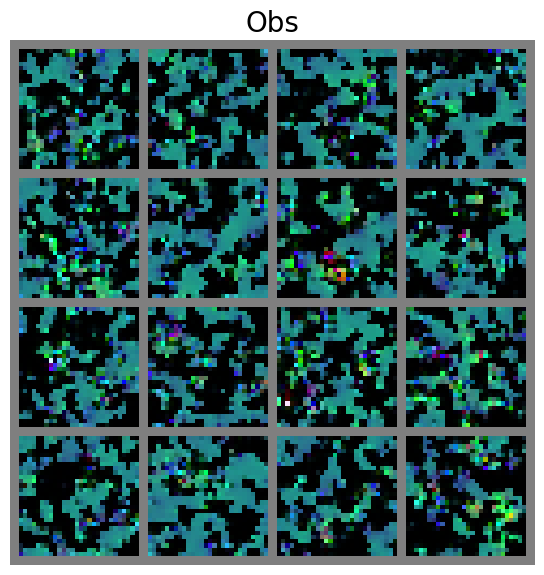

In [8]:
obs_imgs = model.sample(img_shape=[16, 3, 28, 28])
# new_obs_imgs = torch.zeros_like(obs_imgs)
# for idx, image in enumerate(obs_imgs):
#     print(image.min(), image.max())
#     new_image = (image - image.min()) / (image.max() - image.min())
#     new_obs_imgs[idx, ...] = new_image
show_imgs(obs_imgs, title="Obs")

<Axes: ylabel='Count'>

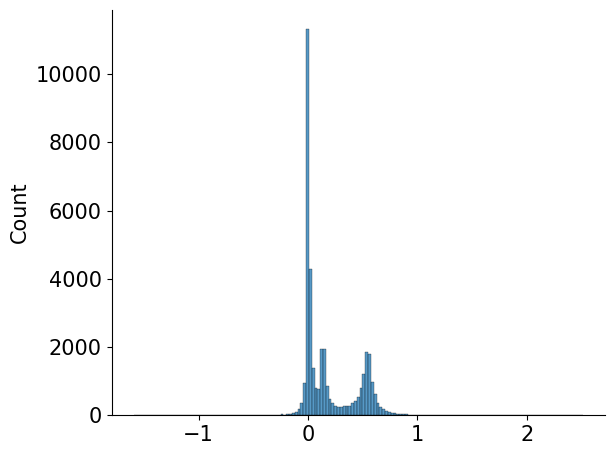

In [9]:
sns.histplot(obs_imgs.flatten())